## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

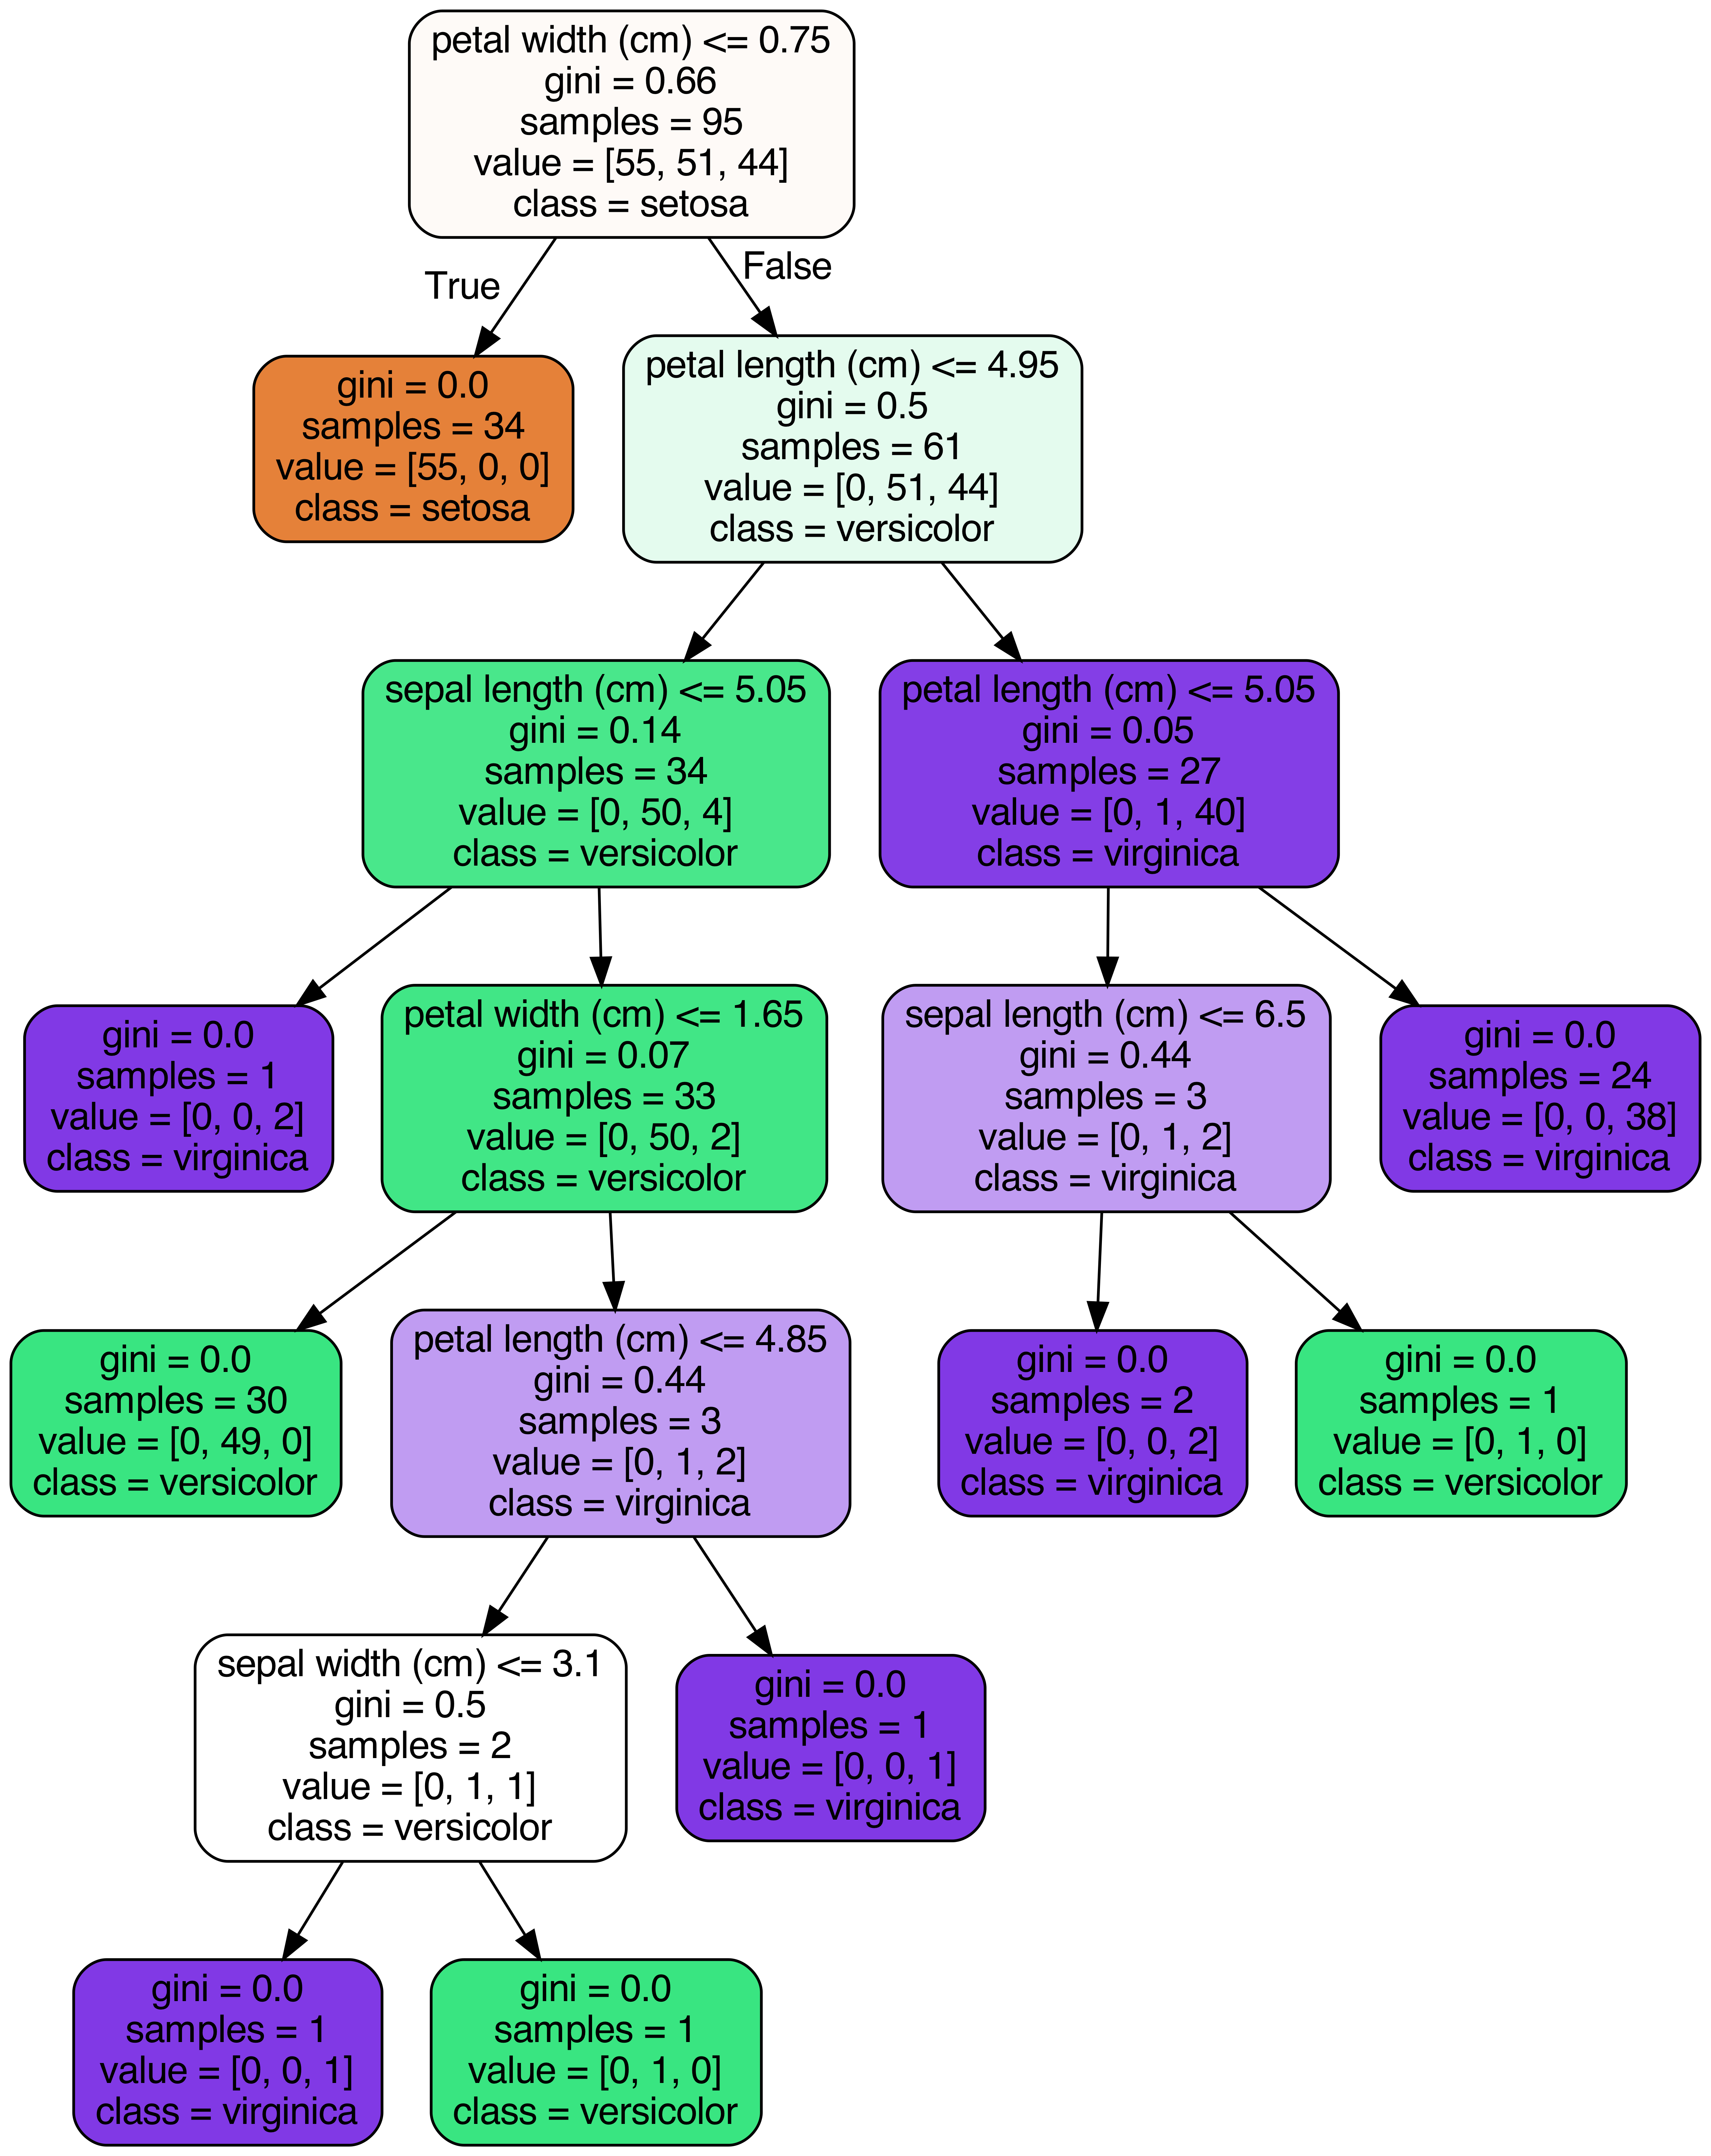

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split separates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='../Covid RandomForest Case Study/PatientInfo.csv'
data = pd.read_csv(url)
df = data
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
print(df['birth_year'])

0       1964.0
1       1987.0
2       1964.0
3       1991.0
4       1992.0
         ...  
2213    1990.0
2214    1998.0
2215    1998.0
2216    1972.0
2217    1974.0
Name: birth_year, Length: 2218, dtype: float64


In [9]:
date = datetime.today()
year = date.year

In [10]:
df = df.assign(n_age = lambda x: year - x['birth_year'])
df['n_age'].describe()

count    1764.000000
mean       47.011338
std        19.412643
min         2.000000
25%        29.000000
50%        47.500000
75%        60.000000
max       106.000000
Name: n_age, dtype: float64

In [11]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [12]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [14]:
df['disease'].fillna(0, inplace=True)

In [15]:
df['disease'] = df['disease'].astype(int)

In [16]:
df['disease'].unique()

array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [17]:
df['global_num'].fillna(np.mean(df['global_num']), inplace=True)
df['birth_year'].fillna(np.mean(df['birth_year']), inplace=True)
df['infection_order'].fillna(np.mean(df['infection_order']), inplace=True)
df['infected_by'].fillna(np.mean(df['infected_by']), inplace=True)
df['contact_number'].fillna(np.mean(df['contact_number']), inplace=True)

In [18]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [19]:
df['new_sex'] = np.where(df['sex'] == 'male', 0, 1)
df['new_sex']

0       0
1       0
2       0
3       0
4       1
       ..
2213    0
2214    0
2215    1
2216    1
2217    0
Name: new_sex, Length: 2218, dtype: int64

In [20]:
df.drop(columns='sex', inplace=True)
df.rename(columns={'new_sex':'sex'}, inplace=True)

In [21]:
df['sex']

0       0
1       0
2       0
3       0
4       1
       ..
2213    0
2214    0
2215    1
2216    1
2217    0
Name: sex, Length: 2218, dtype: int64

In [22]:
df = df.replace({'etc': np.nan})

In [23]:
cols = [col for col in df.columns if (df[col].dtype != object)]

In [24]:
for col in df.columns:
    col = col
    if df[col].dtype == object:
        imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
        imputer = imputer.fit(df[[col]])
        df[[col]] = imputer.transform(df[[col]])
    else:
        imputer = SimpleImputer(strategy='median', missing_values=np.nan)
        imputer = imputer.fit(df[[col]])
        df[[col]] = imputer.transform(df[[col]])
    

 **<font color='teal'> Check for any remaining null values.</font>**

In [25]:
df.isna().sum()

patient_id            0
global_num            0
birth_year            0
age                   0
country               0
province              0
city                  0
disease               0
infection_case        0
infection_order       0
infected_by           0
contact_number        0
symptom_onset_date    0
confirmed_date        0
released_date         0
deceased_date         0
state                 0
n_age                 0
sex                   0
dtype: int64

Remove date columns from the data.


In [26]:
df = df.drop(['symptom_onset_date', 'confirmed_date','released_date','deceased_date'], axis=1)

Review the count of unique values by column.

In [27]:
print(df.nunique())

patient_id         2218
global_num         1304
birth_year           97
age                  11
country               4
province             17
city                133
disease               2
infection_case       15
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
sex                   2
dtype: int64


Review the percent of unique values by column.

In [28]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.059964
disease            0.000902
infection_case     0.006763
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
sex                0.000902
dtype: float64


Review the range of values per column.

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.711136e+01,1.731235e+01,2.000000e+00,3.400000e+01,4.750000e+01,5.700000e+01,1.060000e+02
sex,2218.0,5.933273e-01,4.913236e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Check for duplicated rows

In [30]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age,sex


Print the categorical columns and their associated levels.

In [31]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,age,11
1,country,4
2,province,17
3,city,133
4,infection_case,15
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [32]:
df1=df.select_dtypes(exclude=['object'])
df.corr()

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,n_age,sex
patient_id,1.000000,-0.115774,-0.052142,-3.822030e-02,-2.728051e-02,2.963213e-01,-4.609026e-02,0.055127,0.112250
global_num,-0.115774,1.000000,0.014039,-1.088897e-01,-1.496382e-02,-5.265407e-02,-4.289483e-02,-0.015419,0.045042
birth_year,-0.052142,0.014039,1.000000,-1.039651e-01,-6.883478e-02,2.701688e-02,1.433662e-03,-0.999935,-0.101107
disease,-0.038220,-0.108890,-0.103965,1.000000e+00,3.781665e-16,-1.608674e-16,-1.374432e-17,0.103559,-0.062479
infection_order,-0.027281,-0.014964,-0.068835,3.781665e-16,1.000000e+00,-1.374471e-01,-1.601407e-02,0.068830,0.013064
infected_by,0.296321,-0.052654,0.027017,-1.608674e-16,-1.374471e-01,1.000000e+00,-2.179920e-02,-0.026623,0.034969
contact_number,-0.046090,-0.042895,0.001434,-1.374432e-17,-1.601407e-02,-2.179920e-02,1.000000e+00,-0.001450,-0.029274
n_age,0.055127,-0.015419,-0.999935,1.035593e-01,6.883032e-02,-2.662332e-02,-1.449651e-03,1.000000,0.101998
sex,0.112250,0.045042,-0.101107,-6.247861e-02,1.306412e-02,3.496870e-02,-2.927433e-02,0.101998,1.000000


In [33]:
df.groupby(by=['disease', 'age', 'state']).describe()

patient_id                                            \
                           count          mean           std           min   
disease age  state                                                           
0.0     0s   isolated       21.0  3.709048e+09  2.106941e+09  1.000000e+09   
             released        8.0  3.464875e+09  2.153374e+09  1.000000e+09   
        100s isolated        1.0  6.001001e+09           NaN  6.001001e+09   
        10s  isolated       57.0  3.976947e+09  2.262314e+09  1.000000e+09   
             released       17.0  3.978000e+09  1.945514e+09  1.000000e+09   
        20s  deceased        1.0  6.016000e+09           NaN  6.016000e+09   
             isolated      634.0  4.383997e+09  2.096723e+09  1.000000e+09   
             released       93.0  3.410710e+09  2.310109e+09  1.000000e+09   
        30s  isolated      202.0  3.378569e+09  2.162704e+09  1.000000e+09   
             released       48.0  3.031188e+09  2.123140e+09  1.000000e+09   
        40s  deceased        1.0  6.002000e+09           NaN  6.002000e+09   
             isolated      254.0  3.516764e+09  2.136323e+09  1.000000e+09   
             released       48.0  3.693708e+09  2.093458e+09  1.000000e+09   
        50s  isolated      322.0  3.989991e+09  2.206932e+09  1.000000e+09   
             released       57.0  3.955860e+09  2.377410e+09  1.000000e+09   
        60s  deceased        2.0  1.200003e+09  8.916617e+02  1.200002e+09   
             isolated      204.0  4.396196e+09  2.132605e+09  1.000000e+09   
             released       18.0  3.657889e+09  2.461068e+09  1.000000e+09   
        70s  deceased        5.0  2.163001e+09  2.153333e+09  1.200000e+09   
             isolated       94.0  4.426819e+09  2.090193e+09  1.000000e+09   
             released       15.0  3.103533e+09  2.496171e+09  1.000000e+09   
        80s  deceased        3.0  1.200002e+09  1.129789e+03  1.200001e+09   
             isolated       74.0  5.224838e+09  1.706275e+09  1.000000e+09   
             released        3.0  2.667000e+09  2.887329e+09  1.000000e+09   
        90s  deceased        1.0  1.200004e+09           NaN  1.200004e+09   
             isolated       16.0  5.252000e+09  1.732981e+09  1.000000e+09   
1.0     30s  deceased        1.0  2.000000e+09           NaN  2.000000e+09   
        50s  deceased        6.0  4.413401e+09  2.489088e+09  1.200000e+09   
        60s  deceased        5.0  4.092061e+09  2.640077e+09  1.200001e+09   
        70s  deceased        3.0  1.200004e+09  2.810602e+03  1.200002e+09   
        80s  deceased        4.0  1.653503e+09  9.069977e+08  1.200004e+09   

                                                                               \
                                25%           50%           75%           max   
disease age  state                                                              
0.0     0s   isolated  2.000000e+09  4.100000e+09  6.001001e+09  6.023000e+09   
             released  1.100000e+09  4.100000e+09  4.601500e+09  6.113000e+09   
        100s isolated  6.001001e+09  6.001001e+09  6.001001e+09  6.001001e+09   
        10s  isolated  1.700000e+09  6.001000e+09  6.002000e+09  6.113000e+09   
             released  2.000000e+09  4.100000e+09  6.001000e+09  6.111000e+09   
        20s  deceased  6.016000e+09  6.016000e+09  6.016000e+09  6.016000e+09   
             isolated  2.000000e+09  6.001000e+09  6.008000e+09  7.000000e+09   
             released  1.100000e+09  3.001000e+09  6.001000e+09  7.000000e+09   
        30s  isolated  1.200000e+09  2.000000e+09  6.001000e+09  6.118000e+09   
             released  1.250000e+09  2.000000e+09  6.001000e+09  6.113000e+09   
        40s  deceased  6.002000e+09  6.002000e+09  6.002000e+09  6.002000e+09   
             isolated  1.400000e+09  3.009000e+09  6.001000e+09  7.000000e+09   
             released  1.450000e+09  4.100000e+09  6.001000e+09  7.000000e+09   
        50s  isolated  1.600000e+09  6.001000e+09  6.001000e+09  6.113000

<AxesSubplot:>

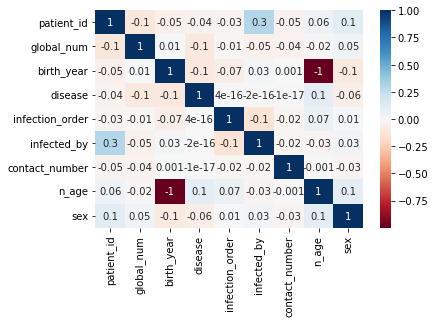

In [34]:
sns.heatmap(df1.corr(), cmap='RdBu', annot=True, fmt='.1g')


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

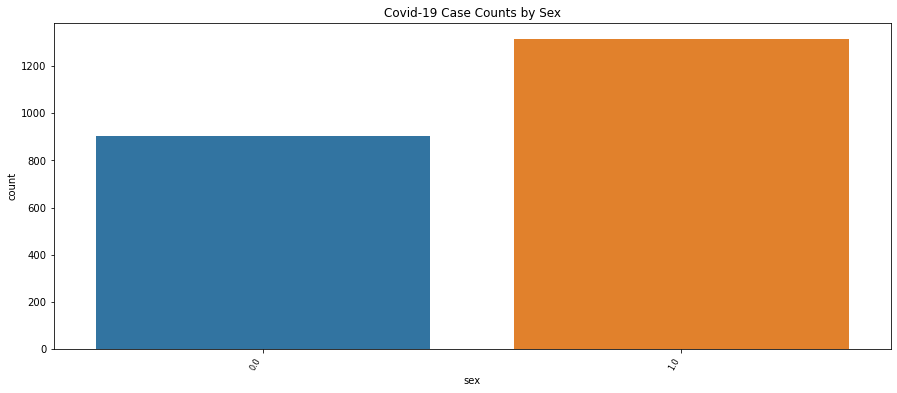

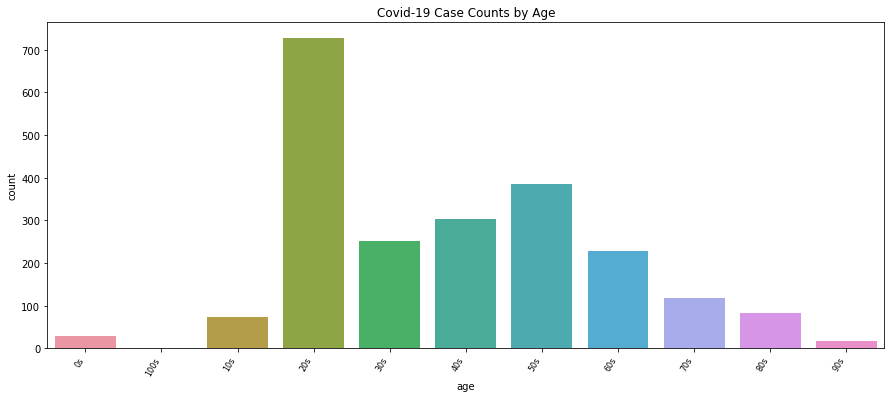

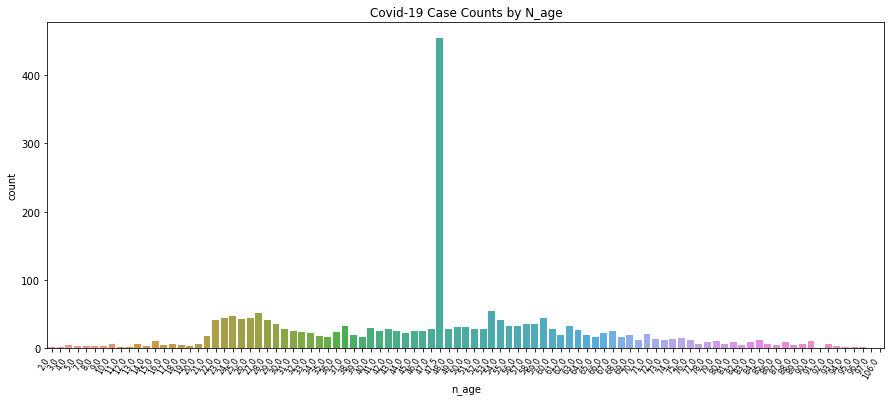

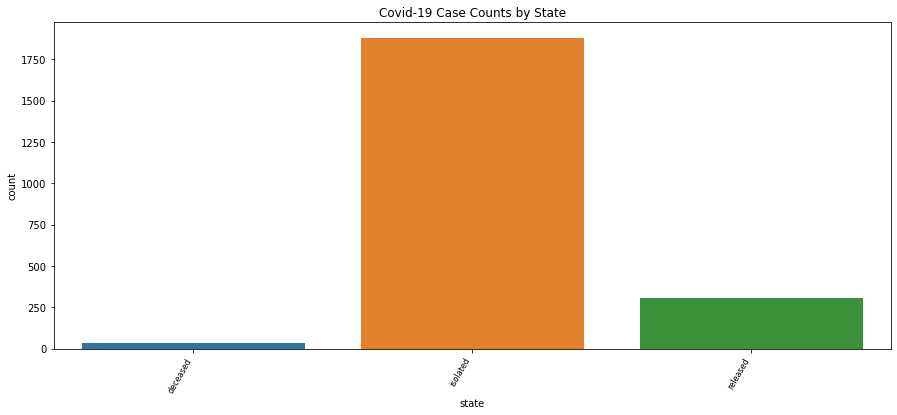

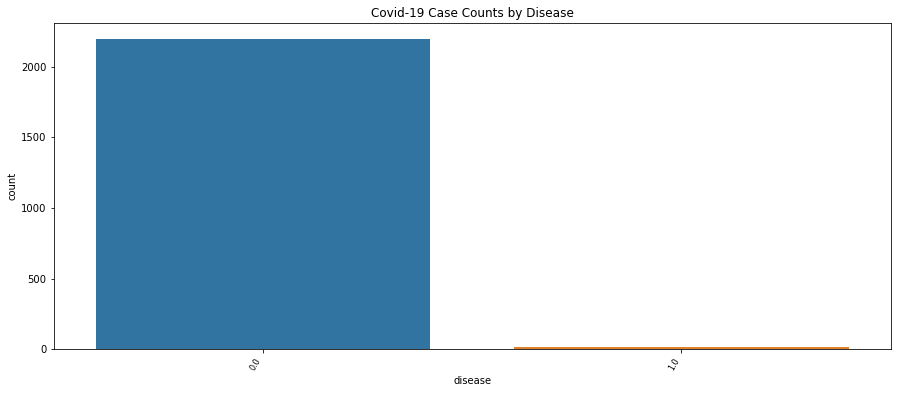

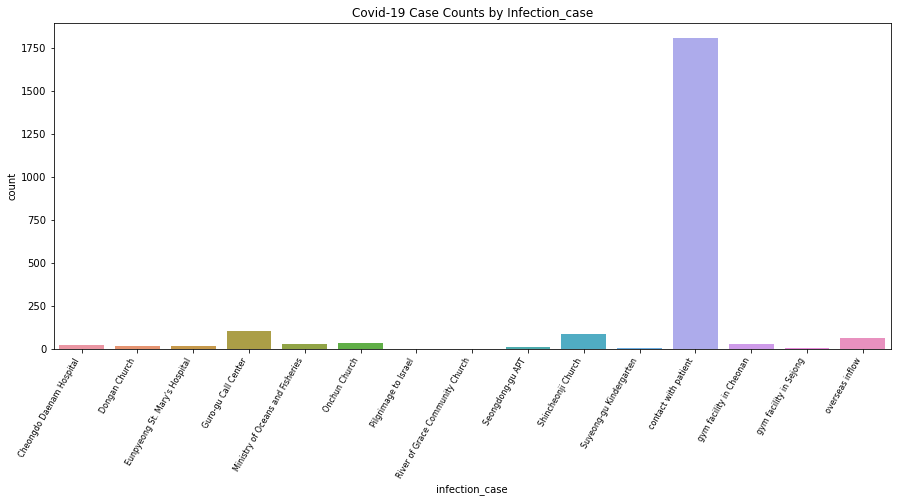

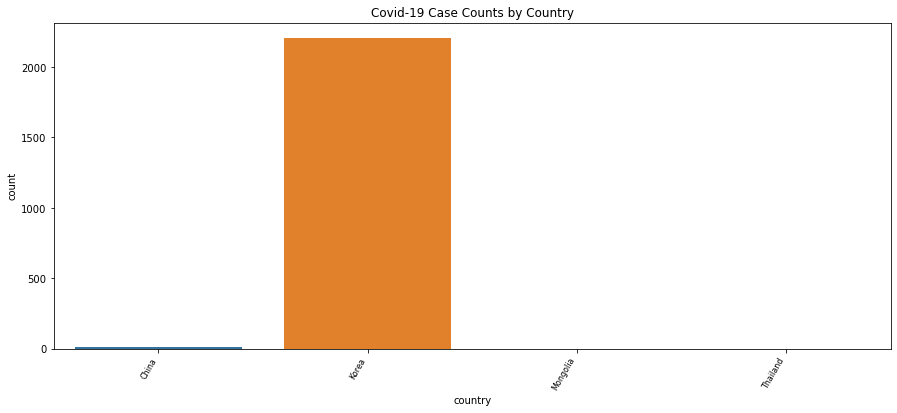

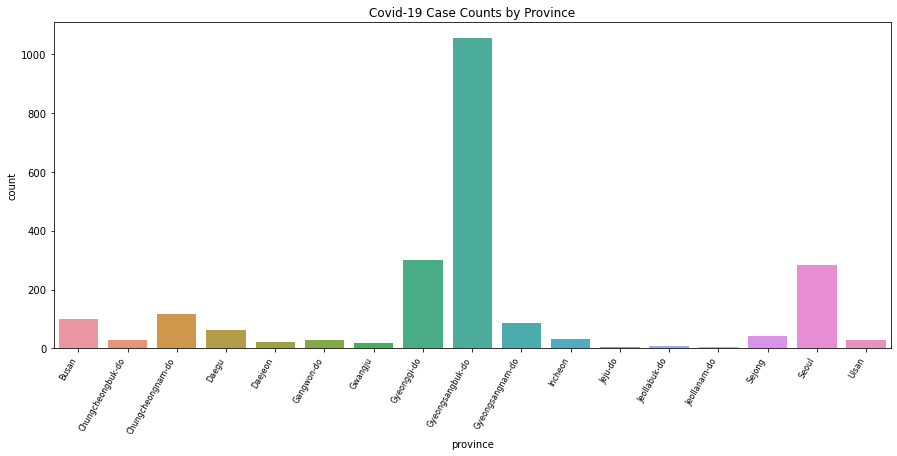

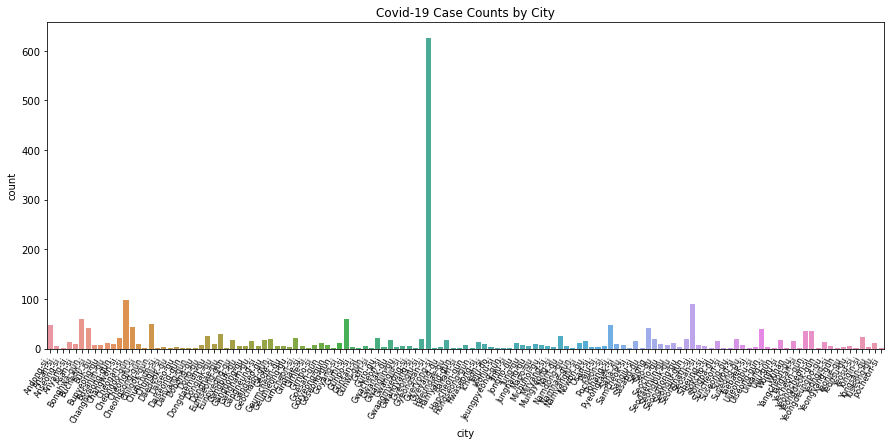

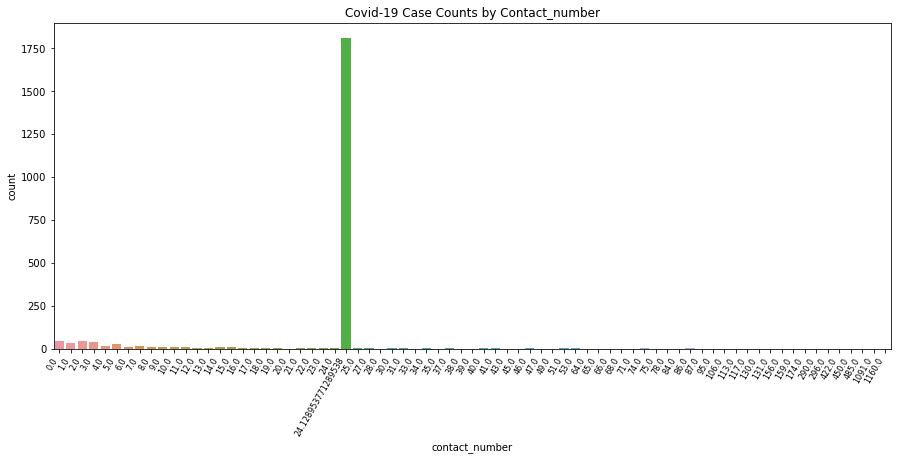

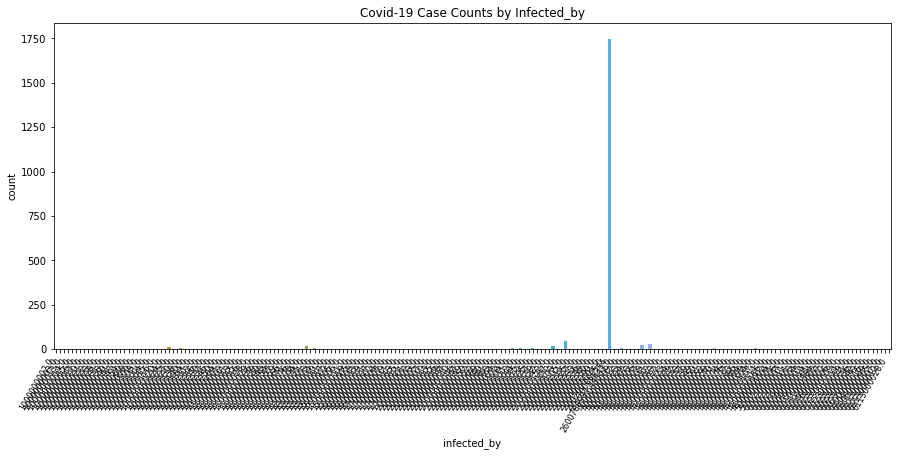

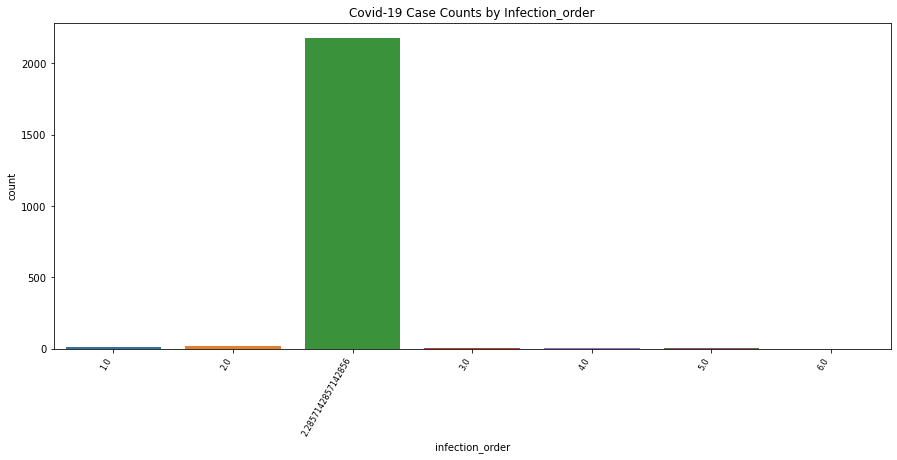

In [35]:
columns = ['sex', 'age', 'n_age', 'state', 'disease', 'infection_case', 'country', 'province', 'city', 'contact_number', 'infected_by', 'infection_order']

for col in columns:
    cols = df[col].sort_values(ascending=True)
    labels = cols.unique()
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    ax = sns.countplot(x=cols, data=df, order=labels)
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)
    ax.set_title
    plt.xlabel(col)
    plt.title('Covid-19 Case Counts by ' + str(col).capitalize())

In [36]:
for col in columns:
    cols = df[col].sort_values(ascending=True)
    print(cols)

0       0.0
1105    0.0
1102    0.0
1101    0.0
1095    0.0
       ... 
369     1.0
1203    1.0
1202    1.0
1200    1.0
1108    1.0
Name: sex, Length: 2218, dtype: float64
1797     0s
1024     0s
347      0s
1033     0s
353      0s
       ... 
108     90s
1546    90s
1575    90s
1275    90s
440     90s
Name: age, Length: 2218, dtype: object
120       2.0
1219      2.0
1580      3.0
1053      3.0
615       4.0
        ...  
1533     95.0
1432     96.0
1275     96.0
1367     97.0
1577    106.0
Name: n_age, Length: 2218, dtype: float64
917     deceased
428     deceased
429     deceased
430     deceased
431     deceased
          ...   
289     released
290     released
1286    released
284     released
0       released
Name: state, Length: 2218, dtype: object
0       0.0
1482    0.0
1481    0.0
1480    0.0
1479    0.0
       ... 
2026    1.0
431     1.0
2025    1.0
436     1.0
445     1.0
Name: disease, Length: 2218, dtype: float64
2024    Cheongdo Daenam Hospital
1988    Cheongdo Daenam 

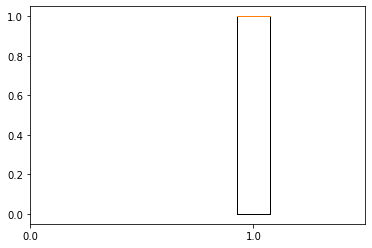

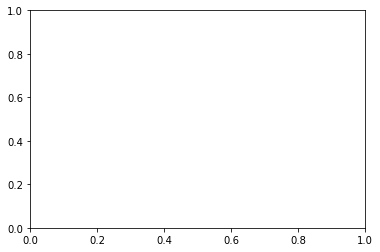

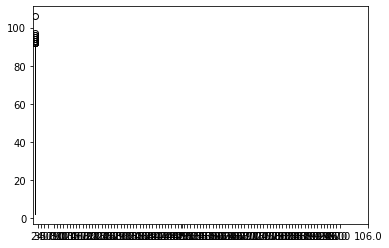

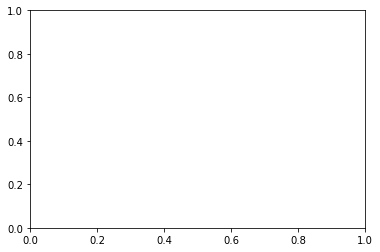

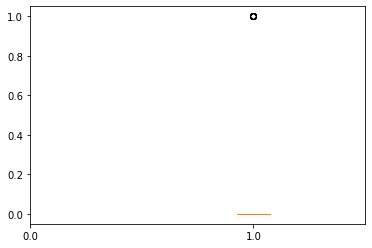

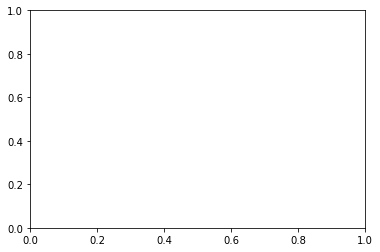

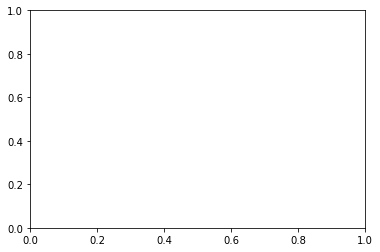

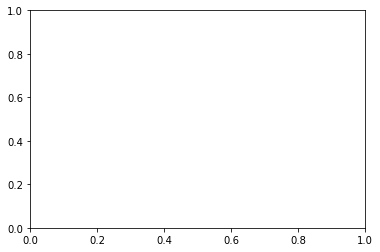

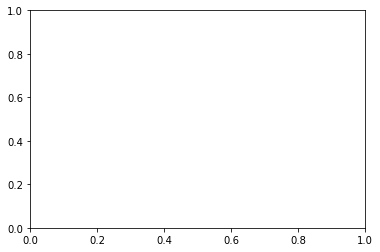

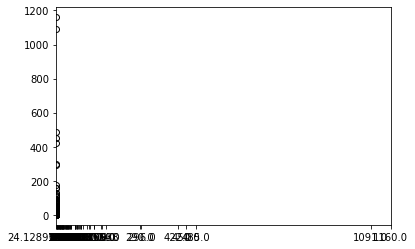

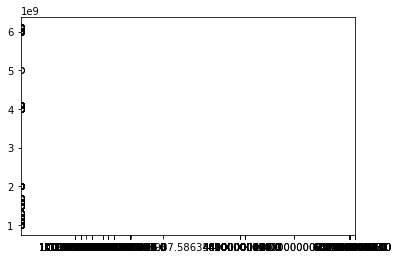

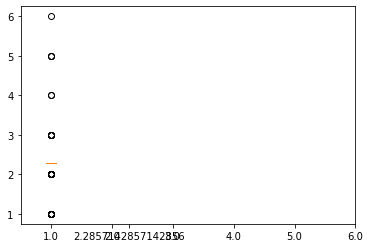

In [37]:
for col in columns:
    cols = df[col].sort_values(ascending=True)
    labels = cols.unique()
    fig, ax = plt.subplots()
    if cols.dtype != object:
        ax.boxplot(cols)
        ax.set_xticks(ticks=labels, labels=labels)

TypeError: Neither the `x` nor `y` variable appears to be numeric.

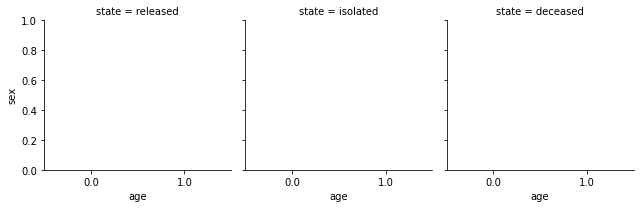

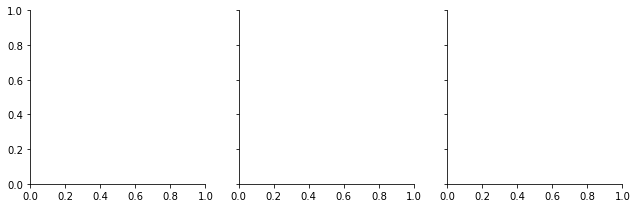

In [38]:
# now do it for boxplots
columns = ['sex', 'age', 'n_age', 'state', 'disease', 'infection_case', 'country', 'province', 'city', 'contact_number', 'infected_by', 'infection_order']

for col in columns:
    cols = df[col].sort_values(ascending=True)
    labels = cols.unique()
    g = sns.FacetGrid(df, col='state')
    g.map(sns.boxplot, 'age', col, order=labels)

**<font color='teal'> Create dummy features for object type features. </font>**

In [ ]:
cat_var = df[['age', 'country', 'province', 'city', 'infection_case', 'state']]
df3 = df.copy()
df3.drop(columns=['age', 'country', 'province', 'city', 'infection_case', 'state'], inplace=True)
dummies = pd.get_dummies(cat_var)

In [ ]:
df3 = pd.concat([df3, dummies], axis=1)
df3

### Split the data into test and train subsamples

In [1080]:
df3.info()

Index(['patient_id', 'global_num', 'birth_year', 'disease', 'infection_order',
       'infected_by', 'contact_number', 'n_age', 'sex', 'age_0s',
       ...
       'infection_case_Seongdong-gu APT', 'infection_case_Shincheonji Church',
       'infection_case_Suyeong-gu Kindergarten',
       'infection_case_contact with patient',
       'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow', 'state_deceased', 'state_isolated',
       'state_released'],
      dtype='object', length=192)

In [1084]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
features = list(df3.columns.drop(['state_deceased', 'state_isolated', 'state_released']))
X = df3[features]
y = df3[['state_deceased', 'state_isolated', 'state_released']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [1085]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [1087]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve,accuracy_score,log_loss
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [1100]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[0][1]

In [1105]:
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

ValueError: multilabel-indicator is not supported

array([0.99666667, 0.00333333])

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [ ]:
class_names=['isolated','released','missing','deceased'] # name  of classes

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [ ]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.